# Lab11-1_108032053

## 1. Download data

In [58]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

import urllib.request
import zipfile

In [59]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

In [3]:
DOWNLOAD_URL = "https://drive.google.com/u/0/uc?id=1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx&export=download&confirm=t&uuid=35c35100-4c41-4839-92fd-0fa13173ebd9&at=AB6BwCDum8cGE5OvfV1Nj6VO88GC:1699340258687"

# Download the zip file
if not os.path.exists("oregon_wildlife.zip"):
    urllib.request.urlretrieve(DOWNLOAD_URL, "oregon_wildlife.zip")

# Unzip the file
with zipfile.ZipFile("oregon_wildlife.zip", "r") as f:
    f.extractall("./")

In [60]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/virginia_opossum
oregon_wildlife/black_bear
oregon_wildlife/bald_eagle
oregon_wildlife/sea_lions
oregon_wildlife/deer
oregon_wildlife/red_fox
oregon_wildlife/raven
oregon_wildlife/raccoon
oregon_wildlife/nutria
oregon_wildlife/cougar

total img num: 7168


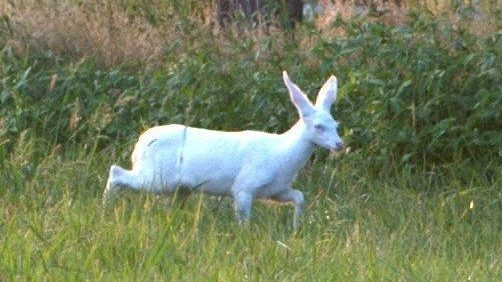

deer


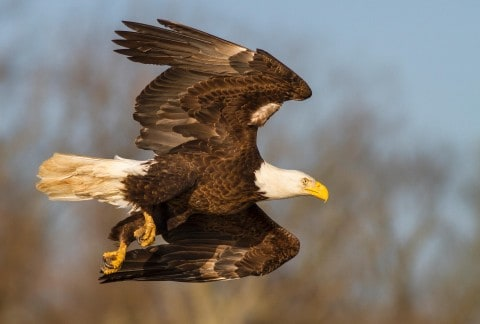

bald_eagle


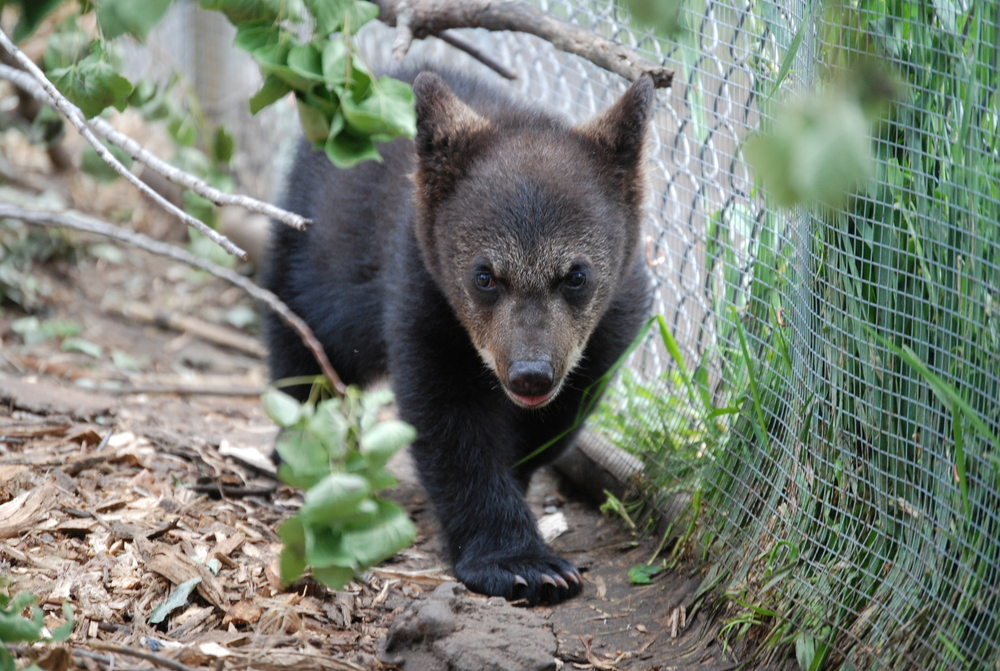

black_bear


In [61]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [62]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']
{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}
First 10 label indices:  [4, 7, 0, 7, 9, 0, 1, 9, 1, 9]
training data: 5734
testing data: 1434


In [63]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])

with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

## 2. Create dataset with time information

In [64]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [65]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [66]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

## 3. Define Model

In [67]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output))

wild_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [68]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

## 4. Define Training

In [69]:
# loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [70]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [71]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

## 5. Define map function

In [72]:
def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.float32)
        )
    return wrapper

### 5.1 Naive

In [51]:
@map_decorator
def map_fun_train_naive(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1, 2, 0]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           image,\
           label

@map_decorator
def map_fun_test_naive(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1, 2, 0]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           image,\
           label

### 5.2 Augmentation

In [52]:
@map_decorator
def map_fun_train_augmentation(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1, 2, 0]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_augmentation(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1, 2, 0]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

### 5.3 Optimized

In [53]:
@map_decorator
def map_fun_train_optimized(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_optimized(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.1)
    
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

## 6. Training with different dataset setting

### 6.1 Naive

In [54]:
BUFFER_SIZE = 10000
BATCH_SIZE = 1

dataset_train_naive = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                              .batch(BATCH_SIZE, drop_remainder=True)
                                              
dataset_test_naive = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                             .batch(BATCH_SIZE, drop_remainder=True)

wild_model.load_weights('wild_model.h5')

timeline_naive = timelined_benchmark(dataset_train_naive, dataset_test_naive, EPOCHS=3)

start time:  25650073.15579687
training:


100%|██████████| 5734/5734 [10:43<00:00,  8.91it/s]

testing:



100%|██████████| 1434/1434 [02:40<00:00,  8.91it/s]

Epoch 1, Loss: 4.7988, Accuracy: 11.1789, test Loss: 2.3010, test Accuracy: 12.2036
training:



100%|██████████| 5734/5734 [10:51<00:00,  8.81it/s]

testing:



100%|██████████| 1434/1434 [02:41<00:00,  8.86it/s]

Epoch 2, Loss: 2.9375, Accuracy: 10.8825, test Loss: 2.3033, test Accuracy: 8.7169
training:



100%|██████████| 5734/5734 [10:55<00:00,  8.75it/s]

testing:



100%|██████████| 1434/1434 [02:41<00:00,  8.90it/s]

Epoch 3, Loss: 2.4299, Accuracy: 10.8999, test Loss: 2.2928, test Accuracy: 10.5997
Execution time: 2433.91438280046


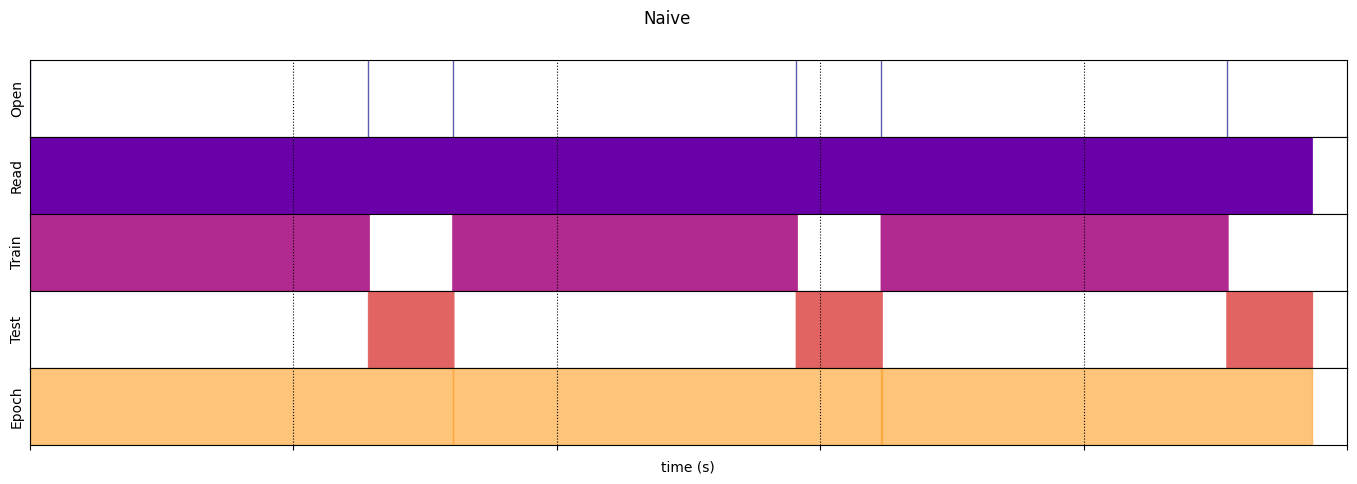

In [77]:
draw_timeline(timeline=timeline_naive, title="Naive", min_width=2500)

### 6.2 Augmentation

In [73]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                                     .shuffle(BUFFER_SIZE)\
                                                     .batch(BATCH_SIZE, drop_remainder=True)
                                              
dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                                    .shuffle(BUFFER_SIZE)\
                                                    .batch(BATCH_SIZE, drop_remainder=True)

wild_model.load_weights('wild_model.h5')

timeline_augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  25656577.11602991
training:


100%|██████████| 89/89 [02:24<00:00,  1.63s/it]  

testing:



100%|██████████| 22/22 [00:38<00:00,  1.73s/it]

Epoch 1, Loss: 5.1754, Accuracy: 26.8258, test Loss: 1.2079, test Accuracy: 66.2642
training:



100%|██████████| 89/89 [01:45<00:00,  1.18s/it] 

testing:



100%|██████████| 22/22 [00:24<00:00,  1.10s/it]

Epoch 2, Loss: 1.1028, Accuracy: 61.5871, test Loss: 0.6397, test Accuracy: 80.6108
training:



100%|██████████| 89/89 [01:44<00:00,  1.17s/it] 

testing:



100%|██████████| 22/22 [00:24<00:00,  1.13s/it]

Epoch 3, Loss: 0.8195, Accuracy: 72.1032, test Loss: 0.5707, test Accuracy: 82.7415
Execution time: 441.30295284092426


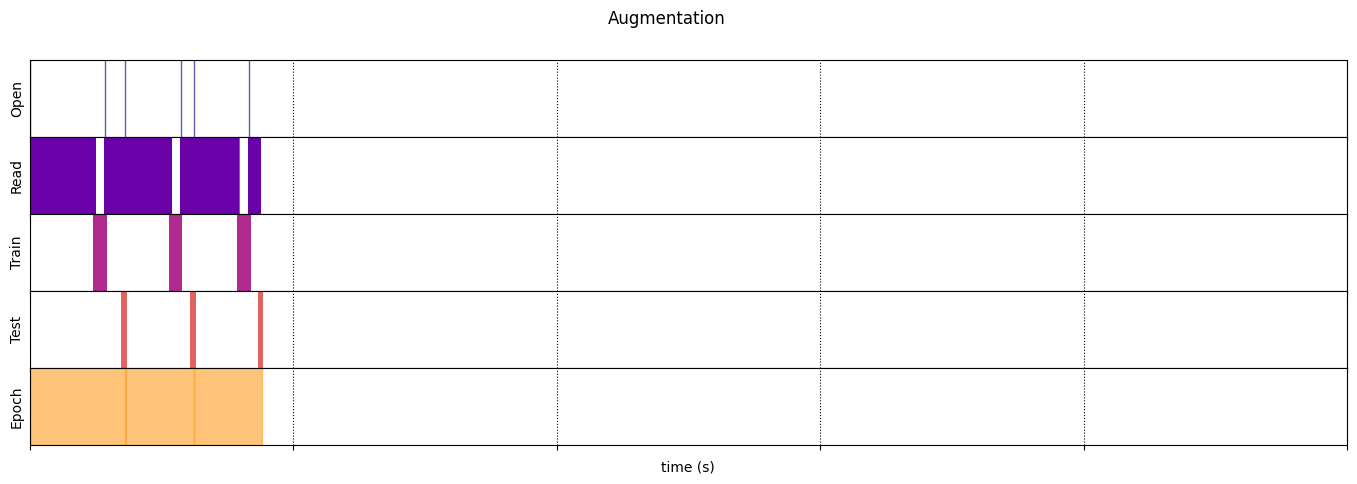

In [78]:
draw_timeline(timeline=timeline_augmentation, title="Augmentation", min_width=2500)

### 6.3 Optimized

In [75]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

wild_model.load_weights('wild_model.h5')

timeline_optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  25657066.073597647
training:


100%|██████████| 89/89 [01:50<00:00,  1.24s/it] 

testing:



100%|██████████| 22/22 [00:21<00:00,  1.00it/s]

Epoch 1, Loss: 5.7672, Accuracy: 22.4192, test Loss: 1.5523, test Accuracy: 45.5256
training:



100%|██████████| 89/89 [00:19<00:00,  4.51it/s]

testing:



100%|██████████| 22/22 [00:04<00:00,  4.67it/s]

Epoch 2, Loss: 1.3336, Accuracy: 51.3167, test Loss: 0.7919, test Accuracy: 77.1307
training:



100%|██████████| 89/89 [00:19<00:00,  4.48it/s]

testing:



100%|██████████| 22/22 [00:04<00:00,  4.65it/s]

Epoch 3, Loss: 0.8965, Accuracy: 68.5042, test Loss: 0.5546, test Accuracy: 83.8778
Execution time: 181.52824990823865


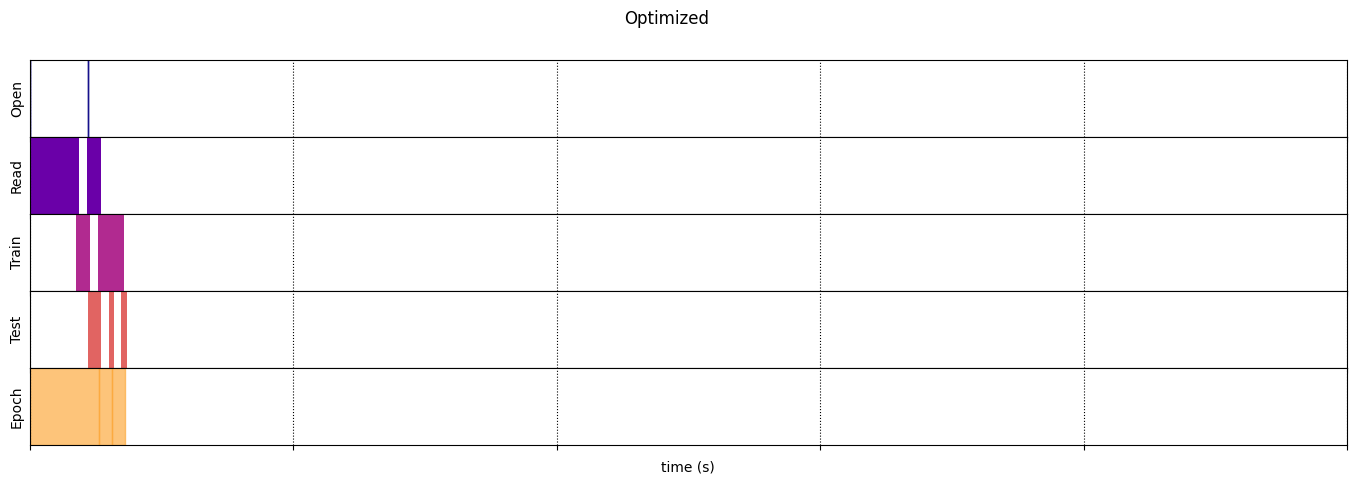

In [79]:
draw_timeline(timeline=timeline_optimized, title="Optimized", min_width=2500)

## 7. Report

### 7.1 Naive & Augmentation

在Augmentation的部分，我增加了shuffle，並提高了batch size，同時我原先也有嘗試增加map function在第5點的部分，對圖片做一些transformation，但為了解決synchronization的問題，所加入的time.sleep就算增加到0.1還是一直遇到error，若再往上提升，帶來的overhead實在太大了，大大增加training的時間，因此最終我選擇捨去使用map function。

雖然最後只有使用增加shuffle和batch size，但依然可以看出accuracy進步非常多，從原先只有約10%的準確率增加到80%以上，而且將batch size從1提高到64後也讓training的時間加快非常多，從原先的約2400秒變成約440秒，總共快了5倍多。

### 7.2 Augmentation & Optimized

在Optimized也和Augmentation一樣，因為map function的overhead太大，只好把他拿掉，但我額外加上了許多可以增加平行度的方法來減少training時間，如interleave(num_parallel_calls)和prefetch，也加上了cache儲存資料，讓後面的epoch都不用再去重新read資料，讓整體training時間下降至約180秒，比起Augmentation又快上了2倍多。

從timeline上可以看到Naive的read會是bottleneck，主要時間幾乎都在等待read；接著Augmentation時，增加的batch size使得每個階段的時間都大大縮短，但read依然為bottleneck；最後Optimized才透過cache真正解決這個bottleneck，讓之後的epoch不用去重複read同樣的資料，讓IO時間減短，整體時間從原先的2400秒進步為180秒，加速了13倍之多。